In [1]:
import seaborn as sns
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
%pylab inline
import os
from __future__ import print_function
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '.')))
if 'ilya' in os.getcwd():
    os.chdir('/Users/ilya/Documents/Kaggle_Bimbo/')
elif 'romul' in os.getcwd():
    os.chdir('/home/romul/kaggle/Bimbo/')
else:
    os.chdir('/Users/margarita/Kaggle/Bimbo/')

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_train = pd.read_csv('train_sample.csv')
print(data_train.shape)
data_train.head()

(1008073, 24)


,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,...,brand,weight,pieces,Has_choco,Has_vanilla,Has_multigrano,NombreCliente,Dev_proxima_by_uni,No_remains,Log_Demanda
0,3,1110,7,3301,15766,1238,4,39.32,0,0,...,BIM,140,2,0,0,0,PUESTO DE PERIODICOS LAZARO,NaN,0,1.609438
1,3,1110,7,3301,319641,1125,50,480.00,0,0,...,TR,255,10,0,0,0,GUADALAJARA,NaN,0,3.931826
2,3,1110,7,3301,319641,2233,23,458.62,0,0,...,BIM,640,NaN,0,0,0,GUADALAJARA,NaN,0,3.178054
3,3,1110,7,3301,819816,2233,14,279.16,0,0,...,BIM,640,NaN,0,0,0,SANATORIO ESPANOL SA,NaN,0,2.708050
4,3,1110,7,3301,1163700,31506,6,37.50,0,0,...,MLA,113,6,0,0,0,PUESTO DEGALLETAS,NaN,0,1.945910


In [3]:
data_for_model = data_train[['Log_Demanda']].copy()
for c in data_train.columns:
    if data_train[c].dtype.name == 'object': #string
        if data_train[c].value_counts().shape[0] < 34: #states
            data_for_model = pd.concat([data_for_model, pd.get_dummies(data_train[c], dummy_na=False).iloc[:,:-1]]) #without last for non-multicollinearity
        else:
            print(c+': too many values')
    elif c != 'Log_Demanda':
        data_for_model[c] = data_train[c]

Town: too many values
NombreProducto: too many values
brand: too many values
NombreCliente: too many values


In [4]:
data_for_model = data_for_model.fillna(data_for_model.mean())

Случайный лес измеряет важность признаков, по тому насколько сильно они смогли уменьшить значения критерия информативности в совокупности по всем деревьям. Важность нормализована так, что сумма по всем признакам равна 1.0.

In [5]:
def plot_feature_importances(rf, feat_labels): 
    feat_labels = X_train.columns
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title('RF Feature Importances')
    plt.bar(range(X_train.shape[1]), 
            importances[indices],
            color='lightblue', 
            align='center')


    plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.tight_layout()
    plt.savefig('./rf_feature_importance.png', dpi=300)
    plt.show()

Удаляем по одному признаку и смотрим на важность признаков.

MSE 3.43969352858e-07
Dropped features: []


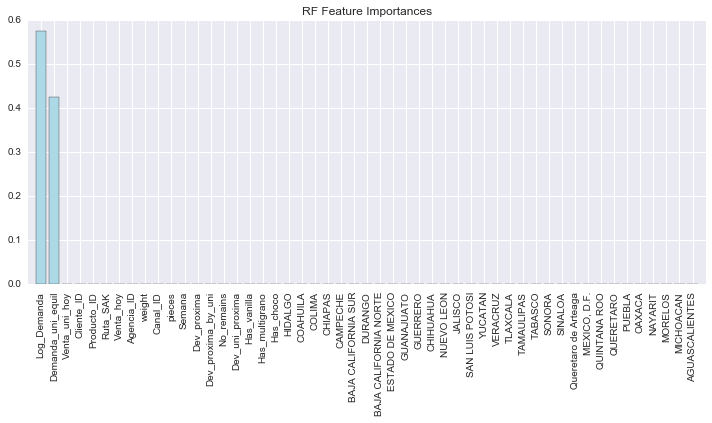

MSE 4.06776429175e-07
Dropped features: ['Log_Demanda']


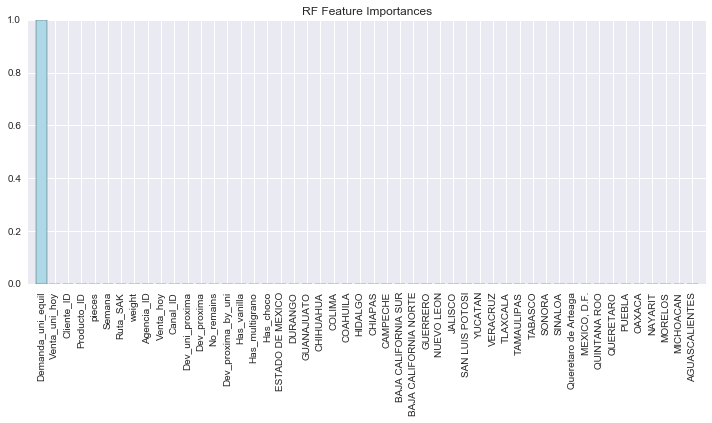

MSE 7.10319877578e-05
Dropped features: ['Log_Demanda', 'Demanda_uni_equil']


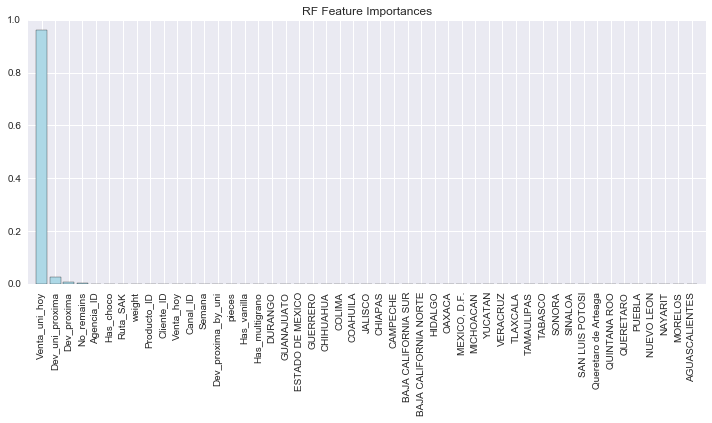

MSE 0.000838823059057
Dropped features: ['Log_Demanda', 'Demanda_uni_equil', 'Venta_uni_hoy']


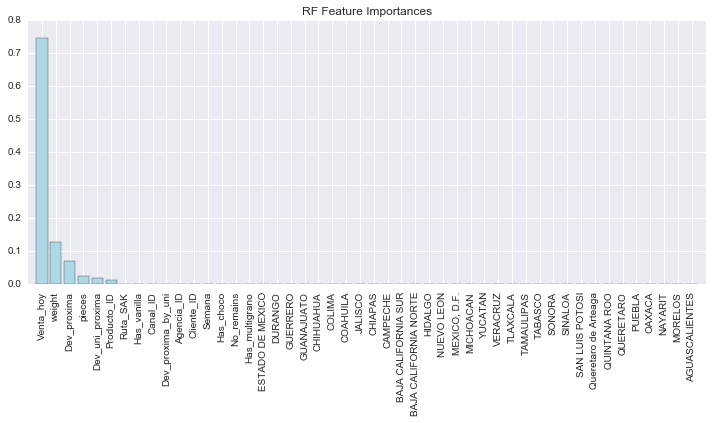

MSE 0.18234167747
Dropped features: ['Log_Demanda', 'Demanda_uni_equil', 'Venta_uni_hoy', 'Venta_hoy']


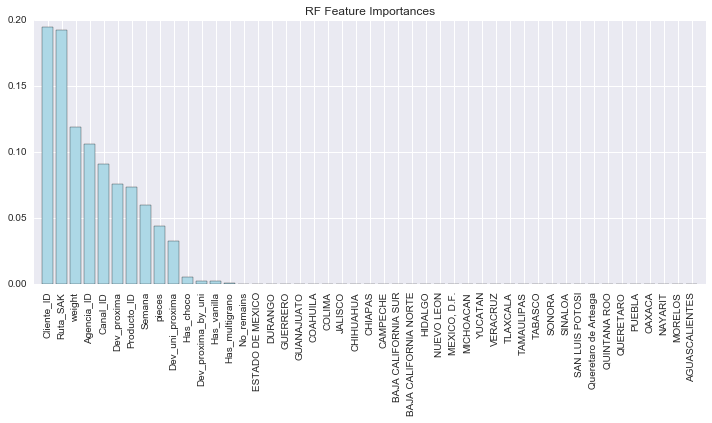

MSE 0.182642132241
Dropped features: ['Log_Demanda', 'Demanda_uni_equil', 'Venta_uni_hoy', 'Venta_hoy', 'Dev_proxima']


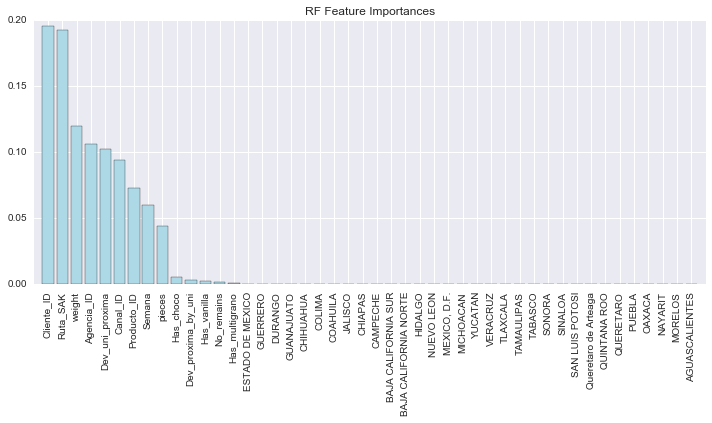

MSE 0.182927646067
Dropped features: ['Log_Demanda', 'Demanda_uni_equil', 'Venta_uni_hoy', 'Venta_hoy', 'Dev_proxima', 'Dev_uni_proxima']


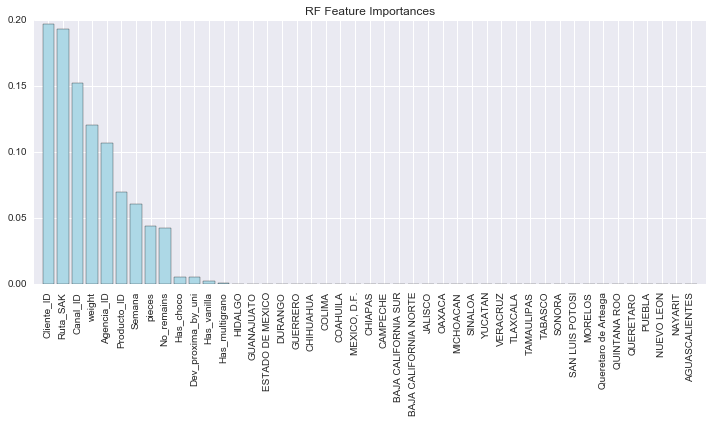

MSE 0.18314830833
Dropped features: ['Log_Demanda', 'Demanda_uni_equil', 'Venta_uni_hoy', 'Venta_hoy', 'Dev_proxima', 'Dev_uni_proxima', 'No_remains']


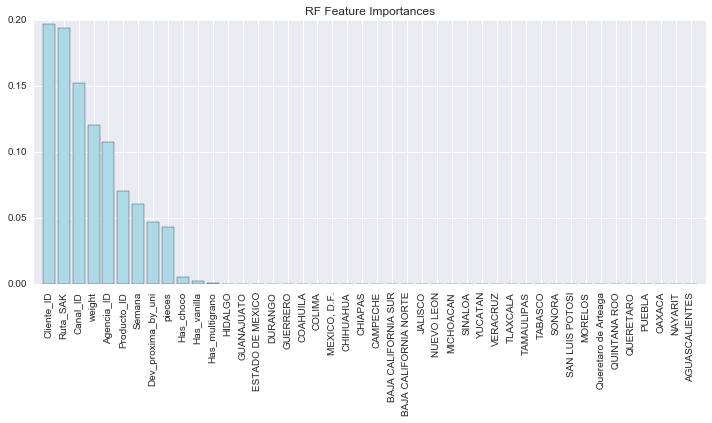

MSE 0.19514510747
Dropped features: ['Log_Demanda', 'Demanda_uni_equil', 'Venta_uni_hoy', 'Venta_hoy', 'Dev_proxima', 'Dev_uni_proxima', 'No_remains', 'Dev_proxima_by_uni']


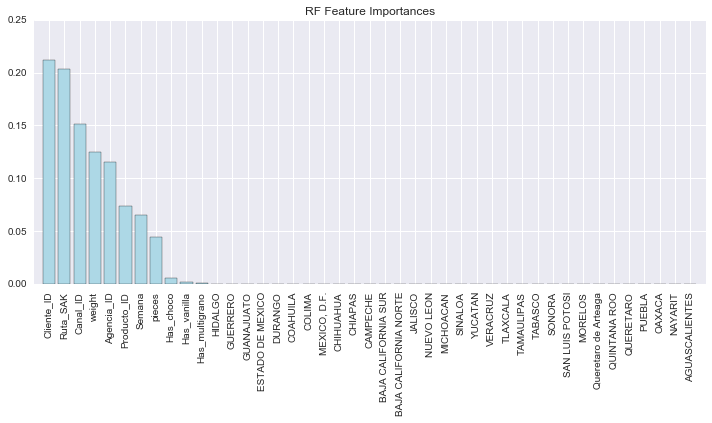

In [6]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

drop_columns = ['Log_Demanda', 'Demanda_uni_equil', 'Venta_uni_hoy', 'Venta_hoy',
                'Dev_proxima', 'Dev_uni_proxima', 'No_remains', 'Dev_proxima_by_uni']

for i in range(len(drop_columns) + 1):
    X_train, X_test, y_train, y_test = train_test_split(data_for_model.drop(drop_columns[:i], axis = 1),
                                                    data_for_model['Log_Demanda'], test_size=0.33, random_state=42)
    rf = RandomForestRegressor(n_estimators=50, criterion='mse', n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print("MSE", mean_squared_error(y_test, y_pred))
    print("Dropped features:", drop_columns[:i])
    plot_feature_importances(rf, X_train.columns)
    

По 'Venta_uni_hoy', 'Venta_hoy' легко восстанавливаются 'Log_Demanda' и 'Demanda_uni_equil'. Если удалить все признаки, которых нет в тестовой выборке, то лес всё равно как-то переобучается.

Мне кажется надо использовать 'Venta_uni_hoy', 'Venta_hoy', 'Dev_proxima', 'Dev_uni_proxima', 'No_remains', 'Dev_proxima_by_uni' неявно, например, вычислять для каждого поставщика среднее по этим признакам, а ещё лучше такие средние для пар (поставщик, клиент), (канал, маршрут) и т.д. Таких фичей можно нагенерить очень много.

Чтобы не переобучаться на таких признаках, нужно генерить их во время кросс-валидации. Вычисляем средние по обучающим фолдам, используем эти признаки при предсказании тестового, таким образом можно будет подбирать гиперпараметры. Но здесь также возможно неявное переобучение, тогда придется делать вложенную cv.

Видео с тренировки, там Станислав Семенов говорил про подобное https://youtu.be/Diw01M5QVfo?t=22m38s